# Wikipedia Pageviews Analytics

## Dependencies

In [ ]:
import boto3
import json
import logging
import random
import seaborn as sns

In [ ]:
%pip install boto3 pandas matplotlib seaborn \
    scikit-learn plotly statsmodels


## S3 Dataset Analysis

In [ ]:


logger = logging.getLogger()
logger.setLevel(logging.INFO)

session = boto3.Session(profile_name='wikipedia', region_name='us-east-1')

# Then create clients/resources from this session
s3 = session.client('s3')

bucket_name = 'wikipedia-pageviews-dev-198328422183-us-east-1'


In [3]:
s3_list_objects = s3.list_objects(Bucket=bucket_name)

In [ ]:
import pandas as pd

pageviews_acc_list = []
count = 0

# loop over files in the bucket
for pageviews_file in [
    s3_object['Key'] for s3_object 
    in s3_list_objects['Contents']
]:
    print(pageviews_file)
    pageviews_payload = s3.get_object(
            Bucket=bucket_name, 
            Key=pageviews_file
        )["Body"].read().decode()
    pageviews = json.loads(pageviews_payload)['items'][0]
    header = {
        'project': 'en.wikipedia', 
        'access': 'all-access', 
        'year': pageviews['year'],
        'month': pageviews['month'],
        'day': pageviews['day']
    }
    logger.info(f"Header: {header}")
    pageviews_df = pd.DataFrame(pageviews['articles'])
    # Add the header to each row of your dataframe
    for column, value in header.items():
        pageviews_df[column] = value
    pageviews_acc_list.append(pageviews_df)
    count += 1
    if count == 60:
        break

pageviews_raw = pd.concat(pageviews_acc_list, ignore_index=True)

In [123]:
def is_content(row):
    """
    Returns True if the pageview row is a content page.

    Args:
        row (pd.Series): a row of the pageviews dataframe
    """
    # prefixes identifying non-content pages
    prefixes = (
        "Category:", 
        "Draft:", 
        "File:",
        "Help:", 
        "Media:",
        "MediaWiki:", 
        "Module:", 
        "Portal:", 
        "Special:", 
        "Template:", 
        "TimedText:", 
        "User:",
        "Wikipedia:"
    )
    article = row['article']
    return not (\
        article in ['Main_Page'] \
            or article.startswith(prefixes) \
            or '_talk:' in article
    )

i = 0

pageviews_all = pageviews_raw.copy()

pageviews_all['is_content'] = pageviews_all.apply(is_content, axis=1)

# Create a new date column from year, month, and day columns
pageviews_all['date'] = pd.to_datetime(pageviews_all[['year', 'month', 'day']])
# Drop the original year, month, and day columns
pageviews_all.drop(columns=['year', 'month', 'day'], inplace=True)
# Drop constant fields
pageviews_all.drop(columns=['project', 'access'], inplace=True)

# Filter out non-content pages
content_pages = pageviews_all[pageviews_all['is_content']]
# Compute the rank for content pages based on pageviews, grouped by date
content_pages['adjusted_rank'] = content_pages.groupby('date')['views'].rank(method='min', ascending=False).astype(int)

# Merge the adjusted rank back to the original DataFrame
#pageviews = pageviews.merge(content_pages[['article', 'date', 'adjusted_rank']], on=['article', 'date'], how='left')

content_pages

,article,views,rank,is_content,date,adjusted_rank
2,Angelsberg,758151,3,True,2015-07-01,1
4,Malware,217855,5,True,2015-07-01,2
6,Terminator_Genisys,170946,7,True,2015-07-01,3
9,Canada_Day,162385,10,True,2015-07-01,4
10,2015_Copa_América,142380,11,True,2015-07-01,5
...,...,...,...,...,...,...
59989,Lost_(TV_series),9492,996,True,2015-10-26,968
59990,Robert_Kardashian,9491,997,True,2015-10-26,969
59991,"Republican_Party_presidential_candidates,_2016",9491,997,True,2015-10-26,969
59992,Vikings_(TV_series),9491,997,True,2015-10-26,969


In [118]:
pageviews

,article,views,rank,is_content,date,adjusted_rank_x,adjusted_rank_y,adjusted_rank
0,Main_Page,20364038,1,False,2015-07-01,NaN,NaN,NaN
1,Special:Search,2034452,2,False,2015-07-01,NaN,NaN,NaN
2,Angelsberg,758151,3,True,2015-07-01,1.0,1.0,1.0
3,User:GoogleAnalitycsRoman/google-api,258566,4,True,2015-07-01,2.0,2.0,2.0
4,Malware,217855,5,True,2015-07-01,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...
59989,Lost_(TV_series),9492,996,True,2015-10-26,973.0,973.0,973.0
59990,Robert_Kardashian,9491,997,True,2015-10-26,974.0,974.0,974.0
59991,"Republican_Party_presidential_candidates,_2016",9491,997,True,2015-10-26,974.0,974.0,974.0
59992,Vikings_(TV_series),9491,997,True,2015-10-26,974.0,974.0,974.0


<Axes: xlabel='article'>

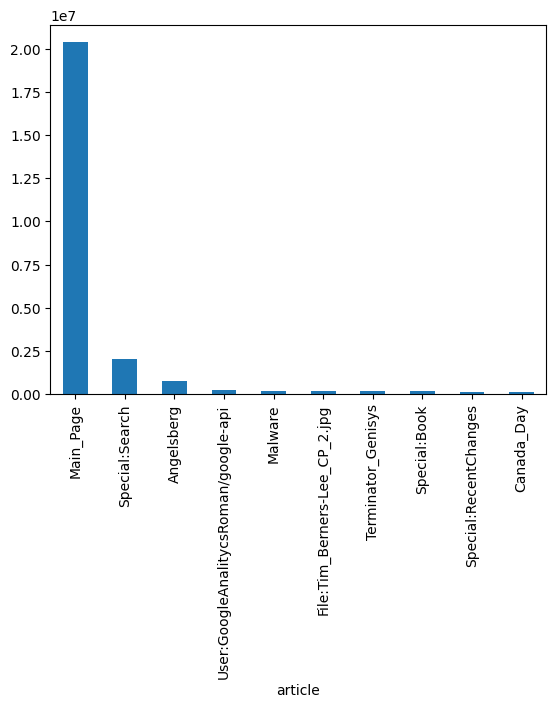

In [67]:
import matplotlib.pyplot as plt
pageviews.iloc[:10][['article', 'views']].plot(kind='bar', x='article', y='views', legend=False)

## Download Pageviews

In [4]:
import datetime

PAGEVIEWS_START_DATE = datetime.datetime(year=2015, month=7, day=1)

def get_pageviews_date_offset(offset: int) -> None:
    ds = PAGEVIEWS_START_DATE + datetime.timedelta(days=offset)
    print(ds.strftime('%Y-%m-%d'))

if __name__ == '__main__':
    for offset in range(0, 10):
        get_pageviews_date_offset(offset)

2015-07-01
2015-07-02
2015-07-03
2015-07-04
2015-07-05
2015-07-06
2015-07-07
2015-07-08
2015-07-09
2015-07-10


In [17]:
import json
import os
import requests
import time

CACHE_ROOT_DIR=f"/tmp"

def cached_download(path: str, url: str) -> bool:
    cache_path = f"{CACHE_ROOT_DIR}/{path}"
    if not os.path.isfile(cache_path):
        print(f"Missed cache. Downloading {url}")
        headers = {
            'User-Agent': 'ralgara@gmail.com'
        }
        time.sleep(0.5)
        req = requests.request("GET", url, headers=headers)
        if req.ok:
            with open(cache_path, 'w') as cache_file:
                cache_file.write(req.text)
            print("Download cached")  
        else:
            print(f'Request failed ({req.status_code}:{req.reason}')
            print(req.text)

    with open(cache_path, 'r') as cache_file:
        print(f"Reading from filesystem: {cache_path}")
        return cache_file.read()
    
def import_pageviews(date) -> str:
    print(f"import_pageviews({date})")
    url_prefix = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/"
    url = url_prefix + date.replace('-','/')
    path = f"pageviews-{date.replace('-','')}"
    print(f"Downloading {url}")
    s = cached_download(path, url)
    doc = json.loads(s)
    return doc['items'][0]['articles'][:10]

import_pageviews('2025-02-11')

import_pageviews(2025-02-11)
Reading from filesystem: /tmp/pageviews-20250211


[{'article': 'Main_Page', 'views': 5179679, 'rank': 1},
 {'article': 'Special:Search', 'views': 1249142, 'rank': 2},
 {'article': 'Kendrick_Lamar', 'views': 508892, 'rank': 3},
 {'article': 'Gulf_of_Mexico', 'views': 429416, 'rank': 4},
 {'article': 'Belle_Gibson', 'views': 338438, 'rank': 5},
 {'article': 'Drake–Kendrick_Lamar_feud', 'views': 326600, 'rank': 6},
 {'article': 'Gina_Rinehart', 'views': 321785, 'rank': 7},
 {'article': 'Serena_Williams', 'views': 318997, 'rank': 8},
 {'article': 'Wikipedia:Featured_pictures', 'views': 265917, 'rank': 9},
 {'article': 'Not_Like_Us', 'views': 242529, 'rank': 10}]

# Visualize ---

In [ ]:
# Wikipedia Pageviews Analysis
# Complete analysis notebook that can be pasted directly into Jupyter
# By Claude Sonnet 3.7 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Function to identify real content pages vs special pages
def is_content(article):
    prefixes = ("Wikipedia:", "MediaWiki:", "Template:", "Help:", "Category:", "Portal:", "Draft:", "TimedText:", "Module:", "Special:", "Media:")
    return not (\
        article in ['Main_Page'] \
            or article.startswith(prefixes) \
            or '_talk:' in article
    )

# 1. Data Preparation
# Convert date columns to datetime and create a single date column
def prepare_data(df, normalize_ranks=True):
    """
    Prepare the dataframe for analysis and optionally normalize ranks
    by removing special/non-content pages
    
    Args:
        df: DataFrame with pageviews data
        normalize_ranks: If True, add normalized ranks excluding special pages
    """
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Create date column from year, month, day if it doesn't exist
    if 'date' not in df.columns:
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    
    # Ensure views is numeric
    df['views'] = pd.to_numeric(df['views'])
    
    # Add is_content flag
    df['is_content'] = df['article'].apply(is_content)
    
    if normalize_ranks:
        # Group by date to normalize ranks within each day
        normalized_ranks = []
        for date, group in df.groupby(['date']):
            # Filter content pages and reset rank
            content_pages = group[group['is_content']].copy()
            content_pages['normalized_rank'] = content_pages['views'].rank(method='dense', ascending=False)
            
            # Add ranks to the result
            normalized_ranks.append(content_pages[['article', 'normalized_rank']])
        
        # Combine all normalized ranks
        if normalized_ranks:
            normalized_df = pd.concat(normalized_ranks)
            # Merge ranks back to original dataframe
            df = df.merge(normalized_df, on='article', how='left')
    
    return df

# 2. Trending Topics Analysis
def analyze_trending_topics(df, window_days=7, content_only=False):
    """
    Identify trending topics by comparing recent views to previous period
    
    Args:
        df: DataFrame with pageviews data
        window_days: Number of days to use for trending window
        content_only: If True, analyze only content pages
    """
    # Filter for content if requested
    if content_only:
        analysis_df = df[df['is_content']].copy()
    else:
        analysis_df = df.copy()
        
    # Get the most recent date in the dataset
    latest_date = analysis_df['date'].max()
    
    # Define current and previous periods
    current_period_start = latest_date - timedelta(days=window_days)
    previous_period_start = current_period_start - timedelta(days=window_days)
    
    # Filter data for both periods
    current_df = analysis_df[(analysis_df['date'] > current_period_start) & (analysis_df['date'] <= latest_date)]
    previous_df = analysis_df[(analysis_df['date'] > previous_period_start) & (analysis_df['date'] <= current_period_start)]
    
    # Aggregate views by article for both periods
    current_views = current_df.groupby('article')['views'].sum().reset_index()
    previous_views = previous_df.groupby('article')['views'].sum().reset_index()
    
    # Merge the data
    trending_df = current_views.merge(previous_views, on='article', suffixes=('_current', '_previous'))
    
    # Calculate growth metrics
    trending_df['absolute_change'] = trending_df['views_current'] - trending_df['views_previous']
    trending_df['percent_change'] = (trending_df['absolute_change'] / trending_df['views_previous'] * 100).round(2)
    
    # Filter for significant traffic (e.g., at least 10000 views in current period)
    trending_df = trending_df[trending_df['views_current'] >= 10000]
    
    # Add content flag
    is_content_map = df.drop_duplicates('article').set_index('article')['is_content'].to_dict()
    trending_df['is_content'] = trending_df['article'].map(is_content_map)
    
    # Sort by percent change
    return trending_df.sort_values('percent_change', ascending=False)

# 3. Page Correlation Analysis
def analyze_page_correlations(df, min_views=5000, top_n=100, content_only=True):
    """
    Identify pages that tend to have correlated view patterns
    
    Args:
        df: DataFrame with pageviews data
        min_views: Minimum views threshold for inclusion
        top_n: Number of top pages to include
        content_only: If True, analyze only content pages (not special pages)
    """
    # Filter for content pages if requested
    if content_only:
        analysis_df = df[df['is_content']].copy()
    else:
        analysis_df = df.copy()
    
    # First, pivot the data to have articles as columns and dates as rows
    pivot_df = analysis_df.pivot_table(index='date', columns='article', values='views', aggfunc='sum')
    
    # Filter to include only pages with significant traffic
    popular_pages = analysis_df.groupby('article')['views'].sum()
    popular_pages = popular_pages[popular_pages > min_views].sort_values(ascending=False).head(top_n).index
    pivot_df = pivot_df[popular_pages]
    
    # Calculate correlation matrix
    corr_matrix = pivot_df.corr()
    
    # Get pairs with high correlation (excluding self-correlations)
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:  # Correlation threshold
                correlated_pairs.append({
                    'page1': corr_matrix.columns[i],
                    'page2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(correlated_pairs).sort_values('correlation', ascending=False)

# 4. Seasonal Pattern Detection
def detect_seasonal_patterns(df, page_name):
    """
    Analyze a specific page for seasonal patterns
    """
    # Filter data for the specific page
    page_df = df[df['article'] == page_name]
    
    # Ensure we have daily data with no gaps
    date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
    page_ts = page_df.set_index('date')['views'].reindex(date_range).fillna(0)
    
    # Apply seasonal decomposition if we have enough data
    if len(page_ts) >= 14:  # Need at least 2 weeks for basic pattern detection
        result = seasonal_decompose(page_ts, model='additive', period=7)  # Weekly seasonality
        return result
    else:
        return None

# 5. Visualize Daily Traffic Patterns
def visualize_daily_patterns(df, top_n=10, content_only=True):
    """
    Visualize daily traffic patterns for top pages
    """
    # Filter for content if requested
    if content_only:
        vis_df = df[df['is_content']].copy()
    else:
        vis_df = df.copy()
    
    # Get top pages by total views
    top_pages = vis_df.groupby('article')['views'].sum().sort_values(ascending=False).head(top_n).index
    top_df = vis_df[vis_df['article'].isin(top_pages)]
    
    # Create time series plot
    plt.figure(figsize=(14, 8))
    for page in top_pages:
        page_data = top_df[top_df['article'] == page]
        plt.plot(page_data['date'], page_data['views'], label=page)
    
    plt.title(f'Daily Views for Top {top_n} {"Content " if content_only else ""}Wikipedia Pages')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.legend()
    plt.grid(True)
    
    return plt

# 6. Weekly Pattern Heatmap
def weekly_pattern_heatmap(df, page_name):
    """
    Create a heatmap showing day-of-week patterns
    """
    page_df = df[df['article'] == page_name].copy()
    
    # Extract day of week from datetime
    page_df['day_of_week'] = page_df['date'].dt.day_name()
    
    # Aggregate by day of week
    weekly_pattern = page_df.groupby('day_of_week')['views'].mean().reset_index()
    
    # Define order of days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_pattern['day_order'] = weekly_pattern['day_of_week'].map({day: i for i, day in enumerate(day_order)})
    weekly_pattern = weekly_pattern.sort_values('day_order')
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='day_of_week', y='views', data=weekly_pattern, order=day_order)
    plt.title(f'Average Daily Views for {page_name} by Day of Week')
    plt.xticks(rotation=45)
    
    return plt

# 7. Interactive Dashboard (for Jupyter)
def create_interactive_dashboard(df, top_n=20, content_only=True):
    """
    Create an interactive Plotly dashboard for the pageviews data
    
    Args:
        df: DataFrame with pageviews data
        top_n: Number of top pages to display
        content_only: If True, show only content pages (no special pages)
    """
    # Filter for content pages if requested
    if content_only:
        dashboard_df = df[df['is_content']].copy()
    else:
        dashboard_df = df.copy()
    
    # Get top pages
    top_pages = dashboard_df.groupby('article')['views'].sum().sort_values(ascending=False).head(top_n)
    
    # Create daily views plot
    daily_content = dashboard_df.groupby('date')['views'].sum().reset_index()
    daily_all = df.groupby('date')['views'].sum().reset_index()
    
    # Create a figure with two traces - all pages and content-only
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(
        x=daily_all['date'], 
        y=daily_all['views'], 
        name='All Pages',
        line=dict(color='blue')
    ))
    
    if content_only:
        fig1.add_trace(go.Scatter(
            x=daily_content['date'], 
            y=daily_content['views'], 
            name='Content Pages Only',
            line=dict(color='green')
        ))
    
    fig1.update_layout(
        title='Daily Wikipedia Pageviews',
        xaxis_title='Date',
        yaxis_title='Views',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    # Create top pages bar chart
    fig2 = px.bar(
        top_pages.reset_index(), 
        x='article', 
        y='views',
        title=f'Top {top_n} {"Content " if content_only else ""}Pages by Views'
    )
    fig2.update_layout(xaxis_tickangle=-45)
    
    # Add a third visualization showing normalized rank distribution
    if 'normalized_rank' in dashboard_df.columns:
        # Get latest date for current ranks
        latest_date = dashboard_df['date'].max()
        current_ranks = dashboard_df[dashboard_df['date'] == latest_date].sort_values('normalized_rank')
        
        fig3 = px.scatter(
            current_ranks.head(50), 
            x='normalized_rank', 
            y='views',
            text='article',
            title='Top 50 Content Pages by Normalized Rank',
            labels={'normalized_rank': 'Normalized Rank', 'views': 'Views'},
            hover_data=['article', 'views', 'normalized_rank']
        )
        
        return fig1, fig2, fig3
    
    return fig1, fig2

# 8. Anomaly Detection
def detect_anomalies(df, z_threshold=3, content_only=True):
    """
    Detect pages with anomalous view counts using Z-score
    
    Args:
        df: DataFrame with pageviews data
        z_threshold: Threshold for Z-score to consider as anomaly
        content_only: If True, analyze only content pages
    """
    # Filter for content if requested
    if content_only:
        analysis_df = df[df['is_content']].copy()
    else:
        analysis_df = df.copy()
        
    # Group by article and date, then calculate stats
    daily_views = analysis_df.groupby(['article', 'date'])['views'].sum().reset_index()
    
    # Group by article to get mean and std for each
    article_stats = daily_views.groupby('article')['views'].agg(['mean', 'std']).reset_index()
    
    # Handle edge cases with zero std
    article_stats['std'] = article_stats['std'].replace(0, 1)
    
    # Merge stats back to daily views
    daily_views = daily_views.merge(article_stats, on='article')
    
    # Calculate Z-scores
    daily_views['z_score'] = (daily_views['views'] - daily_views['mean']) / daily_views['std']
    
    # Filter for anomalies
    anomalies = daily_views[abs(daily_views['z_score']) > z_threshold]
    
    return anomalies.sort_values('z_score', ascending=False)

# 9. Content Page Analysis
def analyze_content_distribution(df):
    """
    Analyze the distribution of content vs non-content pages
    """
    # Group by date and is_content
    content_stats = df.groupby(['date', 'is_content']).agg(
        total_pages=('article', 'nunique'),
        total_views=('views', 'sum')
    ).reset_index()
    
    # Pivot to get content and non-content side by side
    pivot_stats = content_stats.pivot(
        index='date', 
        columns='is_content', 
        values=['total_pages', 'total_views']
    ).reset_index()
    
    # Flatten column names
    pivot_stats.columns = [f"{col[0]}_{col[1]}" if col[1] in [True, False] else col[0] 
                          for col in pivot_stats.columns]
    
    # Calculate percentage of views that are content
    if 'total_views_True' in pivot_stats.columns and 'total_views_False' in pivot_stats.columns:
        pivot_stats['content_view_percentage'] = (
            pivot_stats['total_views_True'] / 
            (pivot_stats['total_views_True'] + pivot_stats['total_views_False']) * 100
        ).round(2)
    
    return pivot_stats

# 10. Temporal Traffic Patterns by Article Type
def analyze_traffic_patterns_by_type(df):
    """
    Compare traffic patterns between content and non-content pages
    """
    # Group by date, hour (if available) and is_content
    # Here we're assuming daily data, but this could be extended for hourly data
    hourly_stats = df.groupby(['date', 'is_content'])['views'].sum().reset_index()
    
    # Create a plot comparing content vs. non-content traffic over time
    fig = plt.figure(figsize=(14, 7))
    
    for content_type, group in hourly_stats.groupby('is_content'):
        label = 'Content Pages' if content_type else 'Special Pages'
        plt.plot(group['date'], group['views'], label=label)
    
    plt.title('Traffic Patterns: Content vs. Special Pages')
    plt.xlabel('Date')
    plt.ylabel('Total Views')
    plt.legend()
    plt.grid(True)
    
    return plt

# 11. Top Pages by Category Analysis
def analyze_top_by_normalized_rank(df, date=None, top_n=50):
    """
    Analyze the top pages by normalized rank for a specific date
    
    Args:
        df: DataFrame with pageviews data
        date: Specific date to analyze (default: latest date)
        top_n: Number of top pages to include
    """
    if not date:
        date = df['date'].max()
    
    # Filter data for the specific date and only content pages
    date_df = df[(df['date'] == date) & (df['is_content'])]
    
    # Sort by normalized rank
    top_pages = date_df.sort_values('normalized_rank').head(top_n)
    
    return top_pages[['article', 'views', 'normalized_rank']]

# 12. Analyze Weekly Distribution
def analyze_weekly_distribution(df, content_only=True):
    """
    Analyze how traffic is distributed across days of the week
    """
    # Filter for content pages if requested
    if content_only:
        analysis_df = df[df['is_content']].copy()
    else:
        analysis_df = df.copy()
    
    # Extract day of week
    analysis_df['day_of_week'] = analysis_df['date'].dt.day_name()
    
    # Aggregate by day of week
    weekly_dist = analysis_df.groupby('day_of_week')['views'].sum().reset_index()
    
    # Calculate percentage
    total_views = weekly_dist['views'].sum()
    weekly_dist['percentage'] = (weekly_dist['views'] / total_views * 100).round(2)
    
    # Define order of days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_dist['day_order'] = weekly_dist['day_of_week'].map({day: i for i, day in enumerate(day_order)})
    
    # Sort by day order
    weekly_dist = weekly_dist.sort_values('day_order')
    
    return weekly_dist[['day_of_week', 'views', 'percentage']]

# ============ MAIN ANALYSIS EXECUTION ============

# Assuming 'pageviews' DataFrame is already loaded with at least 30 days of data

# Run all analyses in sequence
def run_complete_analysis(pageviews):
    print("Starting Wikipedia Pageviews Analysis...")
    
    # 1. Prepare the data
    print("\n1. Preparing data and calculating normalized ranks...")
    df = prepare_data(pageviews, normalize_ranks=True)
    
    # 2. Basic Dataset Overview
    print("\n2. Basic Dataset Overview:")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total unique articles: {df['article'].nunique()}")
    print(f"Content articles: {df[df['is_content']]['article'].nunique()}")
    print(f"Non-content articles: {df[~df['is_content']]['article'].nunique()}")
    
    # 3. Content distribution
    print("\n3. Content vs. Non-Content Distribution:")
    content_stats = analyze_content_distribution(df)
    print(content_stats.head())
    
    # 4. Analyze trending topics
    print("\n4. Trending Content Pages (Last 7 Days):")
    trending = analyze_trending_topics(df, window_days=7, content_only=True)
    print(trending.head(10)[['article', 'views_current', 'views_previous', 'percent_change']])
    
    # 5. Find correlated pages
    print("\n5. Highly Correlated Content Pages:")
    correlations = analyze_page_correlations(df, content_only=True, min_views=1000)
    print(correlations.head(10))
    
    # 6. Detect anomalies
    print("\n6. Content Pages with Anomalous Traffic:")
    anomalies = detect_anomalies(df, content_only=True)
    print(anomalies.head(10)[['article', 'date', 'views', 'mean', 'z_score']])
    
    # 7. Top pages by normalized rank
    print("\n7. Top Content Pages by Normalized Rank (Latest Date):")
    top_normalized = analyze_top_by_normalized_rank(df)
    print(top_normalized.head(10))
    
    # 8. Weekly traffic distribution
    print("\n8. Weekly Traffic Distribution (Content Pages Only):")
    weekly_dist = analyze_weekly_distribution(df, content_only=True)
    print(weekly_dist)
    
    # 9. Create visualizations
    print("\n9. Creating visualizations...")
    
    # Daily traffic patterns
    print("   9.1. Traffic patterns by content type")
    traffic_fig = analyze_traffic_patterns_by_type(df)
    plt.savefig('traffic_patterns.png')
    plt.close()
    
    # Weekly patterns for a popular content page
    print("   9.2. Weekly patterns for a popular content page")
    sample_article = df[df['is_content']].sort_values('views', ascending=False)['article'].iloc[0]
    weekly_fig = weekly_pattern_heatmap(df, sample_article)
    plt.savefig('weekly_pattern.png')
    plt.close()
    
    # Top content pages visualization
    print("   9.3. Top content pages time series")
    top_pages_fig = visualize_daily_patterns(df, content_only=True)
    plt.savefig('top_content_pages.png')
    plt.close()
    
    # Interactive dashboard
    print("   9.4. Creating interactive dashboard")
    dashboard_figs = create_interactive_dashboard(df, content_only=True)
    
    # Save the first dashboard figure
    # In a real notebook, you would display it with dashboard_figs[0].show()
    
    # 10. Seasonal analysis for a popular page
    print("\n10. Seasonal analysis for a popular content page...")
    seasonal = detect_seasonal_patterns(df, sample_article)
    
    if seasonal:
        plt.figure(figsize=(14, 10))
        
        # Plot the original data
        plt.subplot(4, 1, 1)
        plt.plot(seasonal.observed)
        plt.title(f'Observed Traffic for {sample_article}')
        
        # Plot the trend component
        plt.subplot(4, 1, 2)
        plt.plot(seasonal.trend)
        plt.title('Trend Component')
        
        # Plot the seasonal component
        plt.subplot(4, 1, 3)
        plt.plot(seasonal.seasonal)
        plt.title('Seasonal Component (Weekly Pattern)')
        
        # Plot the residual component
        plt.subplot(4, 1, 4)
        plt.plot(seasonal.resid)
        plt.title('Residual Component')
        
        plt.tight_layout()
        plt.savefig('seasonal_analysis.png')
        plt.close()
    
    print("\nAnalysis complete! Check the generated visualizations.")
    return {
        'prepared_data': df,
        'content_stats': content_stats,
        'trending': trending,
        'correlations': correlations,
        'anomalies': anomalies,
        'top_normalized': top_normalized,
        'weekly_distribution': weekly_dist,
        'dashboard': dashboard_figs
    }

# ============ EXECUTION ============
# Uncomment to run the analysis
results = run_complete_analysis(pageviews)

Starting Wikipedia Pageviews Analysis...

1. Preparing data and calculating normalized ranks...

2. Basic Dataset Overview:
Date range: 2015-07-01 00:00:00 to 2015-10-26 00:00:00
Total unique articles: 12423
Content articles: 12322
Non-content articles: 101

3. Content vs. Non-Content Distribution:
        date  total_pages_False  total_pages_True  total_views_False  \
0 2015-07-01                 30               970           23445607   
1 2015-07-02                 31               969           23752130   
2 2015-07-04                 21               979           22731716   
3 2015-07-06                 25               975           25537747   
4 2015-07-08                 34               966           22337023   

   total_views_True  content_view_percentage  
0         525084999                    95.73  
1         524421011                    95.67  
2         487532760                    95.55  
3         568835138                    95.70  
4         517755736             

In [85]:
for panel in results['dashboard']:
    print(panel)
    panel.show()


KeyboardInterrupt: 